In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd

In [2]:
def find_non_zero_files(wb_dir, max_lines=200, subbasin_id=None):
    
    """
    Checks all HYPE water balance files for non-zero and non-NaN values. Returns a list of files with values. 
    Max_lines can be used to reduce computational demand. Can check the full file or just for a given subbasin (useful to
    confirm regionalization)

    Parameters:
    wb_dir (str): The directory path where the files are stored.
    max_lines (int, optional): The maximum number of lines to read from each file for performance optimization. Default is 200.
    subbasin_id (int or str, optional): A specific subbasin ID to check for non-zero values in the file. 
                                        If provided, the function will only check the column corresponding to this subbasin ID.

    Returns:
    list: A list of filenames that contain non-zero, non-NaN values in the specified subbasin column or the entire file.
    """
        
    non_zero_files = []
    
    
    # Iterate through each file in the directory
    for filename in os.listdir(wb_dir):
        if filename.startswith('WB') and filename.endswith('.txt'):
            file_path = os.path.join(wb_dir, filename)
            
            # Load only the first 'max_lines' lines into a DataFrame
            try:
                df = pd.read_csv(file_path, index_col=0, sep='\t', nrows=max_lines)
                
                # Convert only numeric headers to integers, ignore non-numeric ones
                try:
                    df.columns = pd.to_numeric(df.columns, errors='coerce').astype('Int64')  # 'Int64' to allow NaN for non-convertible columns
                except Exception as e:
                    print(f"Error converting headers to integers in {filename}: {e}")
                
                # If subbasin_id is provided, convert it to an integer
                if subbasin_id is not None:
                    try:
                        subbasin_id = int(subbasin_id)
                    except ValueError:
                        print(f"Subbasin ID {subbasin_id} is not a valid integer.")
                        continue
                
                # If subbasin_id is provided and found in columns, filter the DataFrame
                if subbasin_id in df.columns:
                    df = df[[subbasin_id]]
                
                # Check if there are any non-zero and non-NaN values in the DataFrame
                if ((df != 0) & df.notna()).any().any():
                    non_zero_files.append(filename)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    
    return non_zero_files

In [3]:
def find_non_matching_strings(list1, list2):
    """
    Finds and returns a list of strings that do not match between two lists.

    Parameters:
    list1 (list): The first list of strings to compare.
    list2 (list): The second list of strings to compare.

    Returns:
    list: A list of strings that are present in either list1 or list2, but not in both.
    """
    # Convert lists to sets for efficient comparison
    set1 = set(list1)
    set2 = set(list2)
    
    # Find strings that are in list1 but not in list2, and vice versa
    non_matching_from_list1 = set1 - set2
    non_matching_from_list2 = set2 - set1
    
    # Combine the non-matching strings from both lists
    non_matching = list(non_matching_from_list1.union(non_matching_from_list2))
    
    return non_matching

In [4]:
def read_non_zero_files(file_list):
    """
    Reads multiple files into an xarray DataArray from a provided list of filenames.

    Parameters:
    file_list (list): A list of file paths to read.

    Returns:
    xarray.DataArray: An xarray DataArray containing the data from all specified files.
    """
    try:
        # Read all files into a single DataArray
        data_array = xr.open_mfdataset(file_list, combine='by_coords')
        return data_array
    except Exception as e:
        print(f"Error reading files: {e}")
        return None

In [5]:
def read_wb_files(file_list, wb_dir, start_date, end_date):
    """
    Reads multiple text files into a single xarray DataArray with an additional dimension for filenames. Filters to only include the specified date range and returns a WBs DataArray
    with the full range to include initial conditions, as well as a WBf DataArray containing the range except for the first date.

    Parameters:
    file_list (list): A list of filenames to append to the directory path.
    wb_dir (str): The base directory path.
    start_date (str): The start date for filtering the data.
    end_date (str): The end date for filtering the data.

    Returns:
    tuple: A tuple containing two xarray DataArrays:
        - filtered_wbs_components: DataArray containing data within the date range.
        - filtered_wbf_components: DataArray containing data without the first date.
    """
    # Create an empty list to store DataArrays and filenames
    ensemble_member_list = []
    filenames = []

    # Create full file paths
    full_file_paths = [os.path.join(wb_dir, filename) for filename in file_list]
    
    # Read each file and store in the ensemble_member_list
    for path in full_file_paths:
        try:
            # Determine if the filename starts with 'WBs' to skip the first line
            skip_first_line = os.path.basename(path).startswith('WBs')
            # Read the file into a pandas DataFrame
            df = pd.read_csv(path, sep='\t', index_col=0)  # Adjust the separator and index column as needed
            
            # Drop the first row if the filename starts with 'WBs'
            if os.path.basename(path).startswith('WBs'):
                df = df.drop(df.index[0])  # Drop the first row
            
            # Convert the index to datetime and ensure subbasin columns are integers
            df.index = pd.to_datetime(df.index)  # Convert DATE index to datetime
            df.columns = df.columns.astype(int)  # Convert subbasin columns to integers
            
            # Ensure all values are numeric (this may convert non-numeric entries to NaN)
            df = df.apply(pd.to_numeric, errors='coerce')
            
            # Create an xarray DataArray for the current file
            data_array = xr.DataArray(
                df.values,
                dims=('DATE', 'subbasin'),
                coords={'DATE': df.index,
                        'subbasin': df.columns}
            )
            
            # Assign the filename as an additional dimension
            data_array = data_array.expand_dims(wb=1)  # Create a new dimension for the filename
            data_array.attrs['filename'] = os.path.basename(path)  # Optionally store the filename in the attributes

            # Add the DataArray to the ensemble member list
            ensemble_member_list.append(data_array)
            filenames.append(os.path.basename(path).split('.')[0])  # Store the filename without extension
            
        except Exception as e:
            print(f"Error reading {path}: {e}")

    # Concatenate all DataArrays along the new 'wb' dimension
    if ensemble_member_list:
        combined_data_array = xr.concat(ensemble_member_list, dim='wb')  # Concatenate along the wb dimension
        combined_data_array.coords['wb'] = filenames  # Assign the filenames to the new dimension
        
        # Filter the DataArray to include only the specified date range
        filtered_wbs_components = combined_data_array.sel(DATE=slice(start_date, end_date))
        
        # Exclude the first date from the filtered_wbs_components
        first_date = pd.to_datetime(start_date)
        filtered_wbf_components = combined_data_array.sel(DATE=slice(first_date + pd.Timedelta(days=1), end_date))

        # Drop wb dimensions in `filtered_wbs_components` that start with 'WBf'
        filtered_wbs_components = filtered_wbs_components.sel(wb=~filtered_wbs_components.wb.str.startswith('WBf'))

        # Drop wb dimensions in `filtered_wbf_components` that start with 'WBs'
        filtered_wbf_components = filtered_wbf_components.sel(wb=~filtered_wbf_components.wb.str.startswith('WBs'))
        
        filtered_wbf_components.name = 'filtered_wbf_components'
        
        filtered_wbs_components.name = 'filtered_wbs_components'

        return filtered_wbs_components, filtered_wbf_components
    
    return None

In [6]:
def add_precipitation_components(filtered_components):
    """
    Sums precipitation components that start with specific prefixes
    and adds them back into the DataArray with new wb dimensions.

    Parameters:
    filtered_components (xarray.DataArray): The DataArray containing wb dimensions.

    Returns:
    xarray.DataArray: The modified DataArray with new wb dimensions added.
    """
    # Step 1: Sum all components that start with 'WBf_rain'
    rain_subset = filtered_components.sel(wb=filtered_components.wb.str.startswith('WBf_rain'))
    total_rainfall = rain_subset.sum(dim='wb')
    
    # Step 2: Sum all components that start with 'WBf_snow'
    snow_subset = filtered_components.sel(wb=filtered_components.wb.str.startswith('WBf_snow'))
    total_snowfall = snow_subset.sum(dim='wb')
    
    # Step 3: Create 'landclass_precip' as the sum of total_rainfall and total_snowfall
    landclass_precip = (total_rainfall + total_snowfall)
    
    # Step 4: Select and sum all components that start with 'WBf_precipitation'
    precip_subset = filtered_components.sel(wb=filtered_components.wb.str.startswith('WBf_precipitation'))
    total_wbf_precipitation = precip_subset.sum(dim='wb') + landclass_precip
    
    
    # Step 5: Create a new dimension for each of the new components
    total_rainfall = total_rainfall.expand_dims(wb=['total_rainfall'])
    total_snowfall = total_snowfall.expand_dims(wb=['total_snowfall'])
    landclass_precip = landclass_precip.expand_dims(wb=['landclass_precip'])
    total_wbf_precipitation = total_wbf_precipitation.expand_dims(wb=['total_precipitation'])
    
    # Step 6: Concatenate all new wb dimensions back into the original DataArray
    filtered_components = xr.concat(
        [filtered_components, total_rainfall, total_snowfall, landclass_precip, total_wbf_precipitation], 
        dim='wb'
    )

    return filtered_components

In [7]:
def calculate_wbf(filtered_wbf_components):
    """
    Sums the saturated surface runoff for all subbasins and wb entries across the DATE dimension.

    Parameters:
    filtered_wbf_components (xarray.DataArray): The DataArray filtered by date.

    Returns:
    xarray.DataArray: The summed values for each wb and subbasin across the DATE dimension.
    """
    # Sum across the DATE dimension for all subbasins and wb
    wbf_sum = filtered_wbf_components.sum(dim='DATE')

    return wbf_sum

In [8]:
def calculate_wbs(filtered_wbs_components, start_date, end_date):
    """
    Calculates the change in storage for all wb and subbasin entries across a specified date range.

    Parameters:
    filtered_wbs_components (xarray.DataArray): The DataArray filtered by date.
    start_date (str): The start date for calculating the change.
    end_date (str): The end date for calculating the change.

    Returns:
    xarray.DataArray: A DataArray containing the change in storage for each wb and subbasin.
    """
    # Select the values at the start and end of the time period
    first_value = filtered_wbs_components.sel(DATE=start_date)
    last_value = filtered_wbs_components.sel(DATE=end_date)

    # Calculate the change over the time period for each wb and subbasin
    change = last_value - first_value
    
    # Calculate the percentage change over the time period for each wb and subbasin
    percentage_change = ((last_value - first_value) / first_value) * 100

    return change, percentage_change

### Inputs

In [9]:
# directory containing wb outputs
wb_dir= '../../model/model_versions/v_7/v7_1/v7_1_waterbal/'

shapefile_path= '../../geospacial/shapefiles/modified_shapefiles/Modified_SMMcat.shp'

# date range for wb calculations, set to sometime after the first year in the model run to reduce effects of initial conditions
start_date = '1996-10-01'
end_date = '2005-09-30'

### Find Non-Zero WB Components

In [10]:
milk_non_zero_files = find_non_zero_files(wb_dir, subbasin_id=None)

In [11]:
stm_non_zero_files= find_non_zero_files(wb_dir, subbasin_id=58208)

In [12]:
# find WB components that are present in the milk but not the St Mary
non_matching_strings = find_non_matching_strings(stm_non_zero_files, milk_non_zero_files)
print(non_matching_strings)

['WBf_precipitation__ilake.txt', 'WBf_evaporation_ilake_.txt', 'WBs_iwet.txt', 'WBf_snowmelt_via_macropore_snow_soillayer1.txt', 'WBf_flow_lstream_ilake.txt', 'WBf_flow_ilake_mriver.txt', 'WBf_precipitation__iwet.txt', 'WBs_ilake.txt', 'WBf_evaporation_iwet_.txt']


# Water Balance Calculations

In [13]:
# Read WB files into DataArray
filtered_wbs_components, filtered_wbf_components = read_wb_files(milk_non_zero_files, wb_dir, start_date, end_date)

In [14]:
# Find sum of fluxes
filtered_wbf_components= calculate_wbf(filtered_wbf_components)

In [15]:
# Find change in storage
filtered_wbs_components, percentage_change_wbs_components= calculate_wbs(filtered_wbs_components, start_date, end_date)

## Components

### Partitioning

In [16]:
filtered_wbf_components = add_precipitation_components(filtered_wbf_components)

In [17]:
snowfall_frac= filtered_wbf_components.sel(wb='total_snowfall') / filtered_wbf_components.sel(wb='landclass_precip')
rainfall_frac= filtered_wbf_components.sel(wb='total_rainfall') / filtered_wbf_components.sel(wb='landclass_precip')

print(f'Mean Snowfall fraction= {snowfall_frac.mean()}')
print(f'Mean Rainfall fraction= {rainfall_frac.mean()}')

Mean Snowfall fraction= <xarray.DataArray 'filtered_wbf_components' ()>
array(0.33972536)
Mean Rainfall fraction= <xarray.DataArray 'filtered_wbf_components' ()>
array(0.66027464)


### Adjust Snow Storage

In [18]:
# Add back vertical snow changes to only consider horizontal fluxes for 'WBs_snow'
snow_component = filtered_wbs_components.sel(wb='WBs_snow') 

# Modify the 'WBs_snow' slice by adding back vertical fluxes
snow_component_updated = snow_component + (
    filtered_wbf_components.sel(wb='WBf_snowmelt_surfacerunoff_snow_lstream').values + 
    filtered_wbf_components.sel(wb='WBf_snowmelt_via_macropore_snow_soillayer1').values +
    filtered_wbf_components.sel(wb='WBf_snowmelt_via_macropore_snow_soillayer3').values +
    filtered_wbf_components.sel(wb='WBf_snowmelt_snow_soillayer1').values
)

# Assign the updated values back to the original DataArray, only affecting 'WBs_snow'
filtered_wbs_components.loc[{'wb': 'WBs_snow'}] = snow_component_updated

### Land Class Water Balance

In [19]:
# Precipitation
p = filtered_wbf_components.sel(wb='landclass_precip')

# Evapotranspiration
e = (
    filtered_wbf_components.sel(wb='WBf_evaporation_soillayer1_') +
    filtered_wbf_components.sel(wb='WBf_evaporation_soillayer2_') +
    filtered_wbf_components.sel(wb='WBf_evaporation_snow_')
)

# Runoff from land class
r = (
    filtered_wbf_components.sel(wb='WBf_satsurfaceflow_soillayer1_lstream') +
    2 * filtered_wbf_components.sel(wb='WBf_rain_surfacerunoff__lstream') +
    filtered_wbf_components.sel(wb='WBf_snowmelt_surfacerunoff_snow_lstream') +
    filtered_wbf_components.sel(wb='WBf_soilrunoff_soillayer1_lstream') +
    filtered_wbf_components.sel(wb='WBf_soilrunoff_soillayer2_lstream') +
    filtered_wbf_components.sel(wb='WBf_soilrunoff_soillayer3_lstream')
)

# Change in storage
delta_s = (
    filtered_wbs_components.sel(wb='WBs_soillayer1') +
    filtered_wbs_components.sel(wb='WBs_soillayer2') +
    filtered_wbs_components.sel(wb='WBs_soillayer3') +
    filtered_wbs_components.sel(wb='WBs_snow')
)

In [20]:
# calculate the water balance
landclass_balance= p -e - r - delta_s

# Add a new wb dimension labeled 'landclass_error'
landclass_balance = landclass_balance.expand_dims(wb=['landclass_error'])

# Concatenate the landclass_balance with filtered_wbf_components along the wb dimension
filtered_wbf_components = xr.concat([filtered_wbf_components, landclass_balance], dim='wb')

### Internal Wetland

In [21]:
# Calculate internal wetland water balance
iwet_balance= (
    filtered_wbf_components.sel(wb='WBf_precipitation__iwet') + 
    filtered_wbf_components.sel(wb='WBf_evaporation_iwet_') -
    filtered_wbs_components.sel(wb='WBs_iwet')
)

# Add a new wb dimension labeled 'iwet_error'
iwet_balance = iwet_balance.expand_dims(wb=['iwet_error'])

# Concatenate the landclass_balance with filtered_wbf_components along the wb dimension
filtered_wbf_components = xr.concat([filtered_wbf_components, iwet_balance], dim='wb')

### Internal Lakes (Potholes)

In [22]:
# Calculate prairie pothole balance
ilake_balance= (
    filtered_wbf_components.sel(wb='WBf_precipitation__ilake') +
    filtered_wbf_components.sel(wb='WBf_flow_lstream_ilake') -
    filtered_wbf_components.sel(wb='WBf_evaporation_ilake_') -
    filtered_wbf_components.sel(wb='WBf_flow_ilake_mriver') -
    filtered_wbs_components.sel(wb='WBs_ilake')
)

# Add a new wb dimension labeled 'ilake_error'
ilake_balance = ilake_balance.expand_dims(wb=['ilake_error'])

# Concatenate the landclass_balance with filtered_wbf_components along the wb dimension
filtered_wbf_components = xr.concat([filtered_wbf_components, ilake_balance], dim='wb')

### Visualize Error

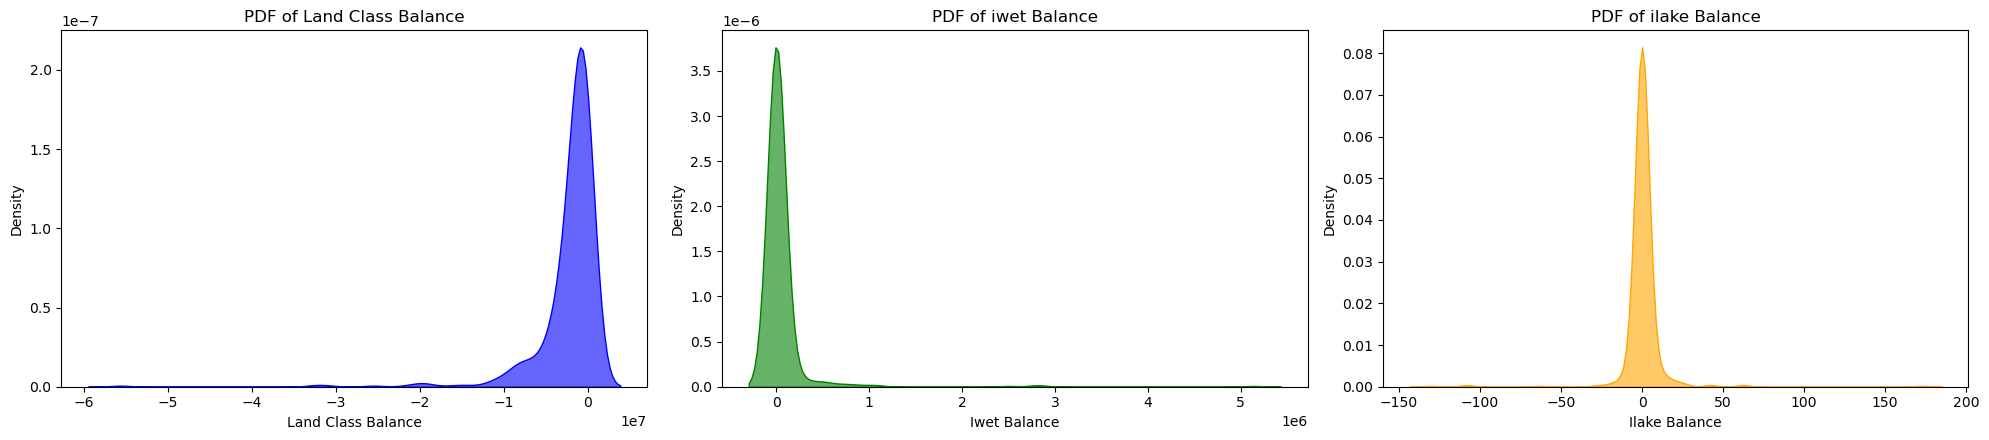

In [23]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 4.5))

# Plot PDF for landclass_balance
sns.kdeplot(filtered_wbf_components.sel(wb='landclass_error').values, fill=True, color='blue', alpha=0.6, ax=axes[0])
axes[0].set_title('PDF of Land Class Balance')
axes[0].set_xlabel('Land Class Balance')
axes[0].set_ylabel('Density')

# Plot PDF for iwet_balance
sns.kdeplot(filtered_wbf_components.sel(wb='iwet_error'), fill=True, color='green', alpha=0.6, ax=axes[1])
axes[1].set_title('PDF of iwet Balance')
axes[1].set_xlabel('Iwet Balance')
axes[1].set_ylabel('Density')

# Plot PDF for ilake_balance
sns.kdeplot(filtered_wbf_components.sel(wb='ilake_error'), fill=True, color='orange', alpha=0.6, ax=axes[2])
axes[2].set_title('PDF of ilake Balance')
axes[2].set_xlabel('Ilake Balance')
axes[2].set_ylabel('Density')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as a PDF
# plt.savefig('balance_subplots.pdf')

# Show the plot
plt.show()

### Summary WB Components

In [24]:
# Sum all components that start with 'WBf_evap'
evap_subset = filtered_wbf_components.sel(wb=filtered_wbf_components.wb.str.startswith('WBf_evaporation'))
total_evap = evap_subset.sum(dim='wb')


# Step 5: Create a new dimension for each of the new components
total_evap = total_evap.expand_dims(wb=['total_evap'])


# Step 6: Concatenate all new wb dimensions back into the original DataArray
filtered_wbf_components = xr.concat([filtered_wbf_components, total_evap], dim='wb')

In [25]:
# Sum all components that start with 'WBf_evap'
total_overland_flow = (
    filtered_wbf_components.sel(wb='WBf_rain_surfacerunoff__lstream') + 
    filtered_wbf_components.sel(wb='WBf_satsurfaceflow_soillayer1_lstream') + 
    filtered_wbf_components.sel(wb='WBf_snowmelt_surfacerunoff_snow_lstream')
)

# Step 5: Create a new dimension for each of the new components
total_overland_flow = total_overland_flow.expand_dims(wb=['total_overland_flow'])


# Step 6: Concatenate all new wb dimensions back into the original DataArray
filtered_wbf_components = xr.concat([filtered_wbf_components, total_overland_flow], dim='wb')

# Runoff Ratio

In [26]:
# Calculate total runoff into the main river
total_runoff = (
    filtered_wbf_components.sel(wb='WBf_flow_lstream_mriver') + 
    filtered_wbf_components.sel(wb='WBf_flow_ilake_mriver')
)

# Calculate the runoff ratio
runoff_ratio = total_runoff / filtered_wbf_components.sel(wb='total_precipitation').values

# Add a new wb dimension labeled 'total_runoff'
total_runoff = total_runoff.expand_dims(wb=['total_runoff'])


# Add a new wb dimension labeled 'total_runoff'
runoff_ratio = runoff_ratio.expand_dims(wb=['runoff_ratio'])

# Concatenate the total_runoff with filtered_wbf_components along the wb dimension
filtered_wbf_components = xr.concat([filtered_wbf_components, total_runoff, runoff_ratio], dim='wb')

# Results Dataframe

In [27]:
shapefile = gpd.read_file(shapefile_path)

shapefile = shapefile.set_index('seg_nhm')

In [28]:
# Assuming 'subbasin' is a dimension in filtered_wbf_components
subbasin_index = filtered_wbf_components.coords['subbasin'].values  # Extract the subbasin dimension as the index

data = {
    'Precipitation': {
        'Landclass Precipitation (%)': filtered_wbf_components.sel(wb='landclass_precip')/filtered_wbf_components.sel(wb='total_precipitation'),
        'Pothole Precipitation (%)': filtered_wbf_components.sel(wb='WBf_precipitation__ilake')/filtered_wbf_components.sel(wb='total_precipitation'),
        'Rainfall Fraction': filtered_wbf_components.sel(wb='total_rainfall') / filtered_wbf_components.sel(wb='total_precipitation'),
        'Snowfall Fraction': filtered_wbf_components.sel(wb='total_snowfall') / filtered_wbf_components.sel(wb='total_precipitation'),
        'Total Precipitation (m3)': filtered_wbf_components.sel(wb='total_precipitation'),
    },
    'Evapotranspiration (fraction of landclass precip)': {
        'ET SL 1': filtered_wbf_components.sel(wb='WBf_evaporation_soillayer1_') / filtered_wbf_components.sel(wb='landclass_precip'),
        'ET SL 2': filtered_wbf_components.sel(wb='WBf_evaporation_soillayer2_') / filtered_wbf_components.sel(wb='landclass_precip'),
        'Sublimation': filtered_wbf_components.sel(wb='WBf_evaporation_snow_') / filtered_wbf_components.sel(wb='landclass_precip'),
        'Landclass ET Flux': (
            (filtered_wbf_components.sel(wb='WBf_evaporation_soillayer1_') + 
             filtered_wbf_components.sel(wb='WBf_evaporation_soillayer2_') + 
             filtered_wbf_components.sel(wb='WBf_evaporation_snow_')) / 
            filtered_wbf_components.sel(wb='landclass_precip')
        )
    },
    'Runoff (fraction of landclass precip)': {
        'Surface Runoff': filtered_wbf_components.sel(wb='total_overland_flow') / filtered_wbf_components.sel(wb='landclass_precip'),
        'SL 1 Flow': filtered_wbf_components.sel(wb='WBf_soilrunoff_soillayer1_lstream') / filtered_wbf_components.sel(wb='landclass_precip'),
        'SL 2 Flow': filtered_wbf_components.sel(wb='WBf_soilrunoff_soillayer2_lstream') / filtered_wbf_components.sel(wb='landclass_precip'),
        'SL 3 Flow': filtered_wbf_components.sel(wb='WBf_soilrunoff_soillayer3_lstream') / filtered_wbf_components.sel(wb='landclass_precip'),
        'Landclass Runoff Flux': (
            (filtered_wbf_components.sel(wb='WBf_satsurfaceflow_soillayer1_lstream') + 
             2 * filtered_wbf_components.sel(wb='WBf_rain_surfacerunoff__lstream') + 
             filtered_wbf_components.sel(wb='WBf_snowmelt_surfacerunoff_snow_lstream') + 
             filtered_wbf_components.sel(wb='WBf_soilrunoff_soillayer1_lstream') + 
             filtered_wbf_components.sel(wb='WBf_soilrunoff_soillayer2_lstream') + 
             filtered_wbf_components.sel(wb='WBf_soilrunoff_soillayer3_lstream')) / 
            filtered_wbf_components.sel(wb='landclass_precip')
        )
    },
    'Change in Storage (percent change)': {
        'Change in Storage SL1': percentage_change_wbs_components.sel(wb='WBs_soillayer1'),
        'Change in Storage SL2': percentage_change_wbs_components.sel(wb='WBs_soillayer2'),
        'Change in Storage SL3': percentage_change_wbs_components.sel(wb='WBs_soillayer3'),
        'Mean Soil Storage Change': (
            np.mean(percentage_change_wbs_components.sel(wb='WBs_soillayer1') + 
            percentage_change_wbs_components.sel(wb='WBs_soillayer2') + 
            percentage_change_wbs_components.sel(wb='WBs_soillayer3'))
        )
    },
    'Wetlands': {
        'Fraction of Precip Falling Here': (
            filtered_wbf_components.sel(wb='WBf_precipitation__iwet')/ 
            (filtered_wbf_components.sel(wb='WBf_precipitation__iwet') + 
             filtered_wbf_components.sel(wb='landclass_precip'))
        ),
        'Evaporation (fraction of inputs)': (
            filtered_wbf_components.sel(wb='WBf_evaporation_iwet_') / 
            (filtered_wbf_components.sel(wb='landclass_precip') + 
             filtered_wbf_components.sel(wb='WBf_precipitation__iwet'))
        ),
        'Change in Storage (fraction of inputs)': percentage_change_wbs_components.sel(wb='WBs_iwet')
    },
    'Prairie Potholes': {
        'Pothole Inflow (%)': (
            filtered_wbf_components.sel(wb='WBf_flow_lstream_ilake') / 
            filtered_wbf_components.sel(wb='landclass_precip')
        ),
        'Pothole Evaporation (% of Inputs)': (
            filtered_wbf_components.sel(wb='WBf_evaporation_ilake_') / 
            (filtered_wbf_components.sel(wb='WBf_precipitation__ilake') + 
             filtered_wbf_components.sel(wb='WBf_flow_lstream_ilake'))
        ),
        'Pothole Outflow (% of Inputs)': (
            filtered_wbf_components.sel(wb='WBf_flow_ilake_mriver') / 
            (filtered_wbf_components.sel(wb='WBf_precipitation__ilake') + 
             filtered_wbf_components.sel(wb='WBf_flow_lstream_ilake'))
        ),
        'Change in Storage (fraction of inputs)': percentage_change_wbs_components.sel(wb='WBs_ilake')
    },
    'Main River (fraction of total precip)': { 
        'Flow from Local Stream (fraction of total runoff)': (
            filtered_wbf_components.sel(wb='WBf_flow_lstream_mriver') / 
            filtered_wbf_components.sel(wb='total_runoff')
        ),
        'Flow from Prairie Potholes (fraction of total runoff)': (
            filtered_wbf_components.sel(wb='WBf_flow_ilake_mriver') / 
            filtered_wbf_components.sel(wb='total_runoff')
        ),  
    },
    'Summary': {
        'Runoff Ratio': filtered_wbf_components.sel(wb='runoff_ratio'),
        'Total ET': (
            filtered_wbf_components.sel(wb='total_evap') / 
            filtered_wbf_components.sel(wb='total_precipitation') 
        ),
        'Total Change in Storage': percentage_change_wbs_components.mean(dim='wb')
    }
}

# Convert dictionary to multi-index DataFrame with 'subbasin' as the index
results = pd.concat({k: pd.DataFrame(v, index=subbasin_index) for k, v in data.items()}, axis=1)

In [29]:
# Define the file path for saving the CSV
wb_results_file_path = wb_dir + 'water_balance_results.csv'

# Save the DataFrame as a CSV file
results.to_csv(wb_results_file_path)

In [30]:
# Create a new DataFrame by copying the original one
levelled_results = results.copy()

# Drop the upper level of the MultiIndex columns in the new DataFrame
levelled_results.columns = levelled_results.columns.droplevel(0)

In [31]:
# Perform the merge
merged_results = shapefile.merge(levelled_results, left_index=True, right_index=True, how='inner')

C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_26176\3839305636.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for the colorbar


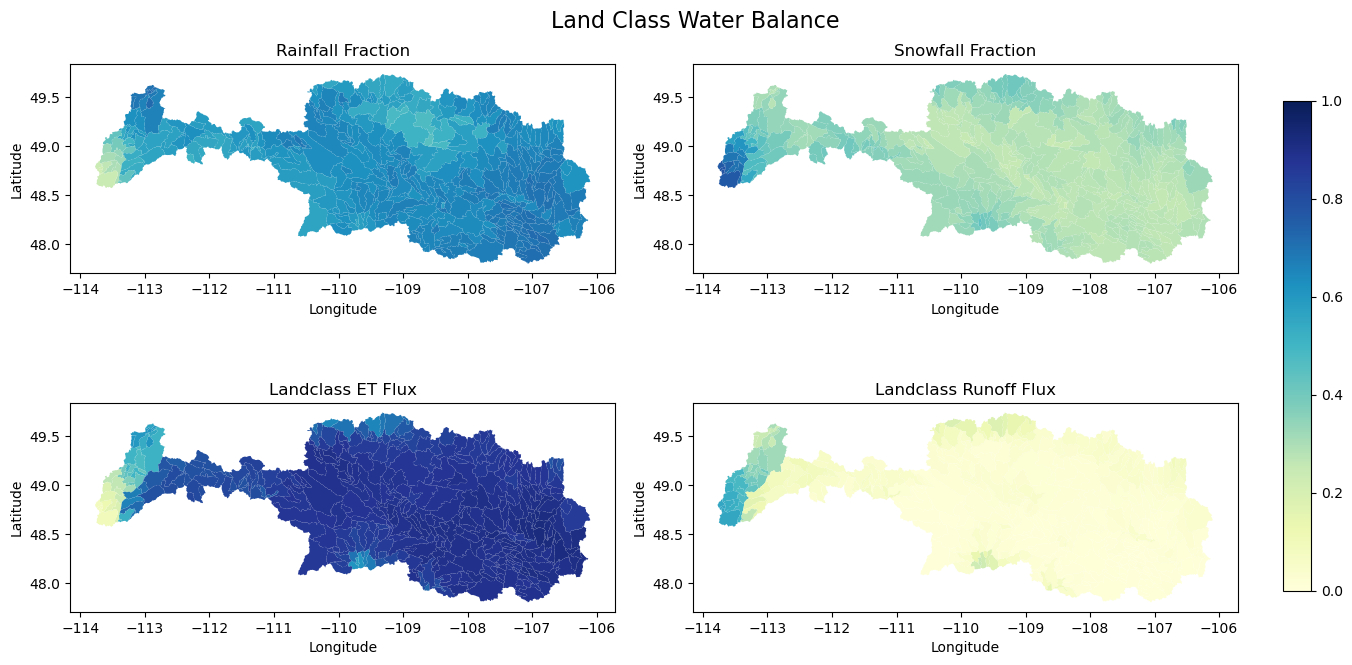

In [32]:
# Ensure all columns exist in the GeoDataFrame
columns_to_plot = ['Rainfall Fraction', 'Snowfall Fraction', 'Landclass ET Flux', 'Landclass Runoff Flux']
missing_columns = [col for col in columns_to_plot if col not in merged_results.columns]

if not missing_columns:
    # Set up the subplots - 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(14, 7))

    # Create a color normalization object to standardize the color range from 0 to 1
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    # Create a colormap to use for all plots
    cmap = 'YlGnBu'  # You can choose any colormap here

    # Plot each column in a different subplot
    for i, (ax, column) in enumerate(zip(axes.flat, columns_to_plot)):
        merged_results.plot(column=column, cmap=cmap, legend=False, ax=ax, norm=norm)
        ax.set_title(column)
        ax.set_xlabel('Longitude') 
        ax.set_ylabel('Latitude')

    # Create a single colorbar for all subplots
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position and size of the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for ScalarMappable
    fig.colorbar(sm, cax=cax)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for the colorbar
    
        # Add a title for the entire plot
    fig.suptitle('Land Class Water Balance', fontsize=16)
    
    # Define the file path for saving the CSV
    wb_heatmap_file_path = wb_dir + 'landclass_heatmap.png'
    
    # Save the figure as a PNG file
    plt.savefig(wb_heatmap_file_path, dpi=300, bbox_inches='tight') 

    # Show the plot
    plt.show()

else:
    print(f"Missing columns: {', '.join(missing_columns)}")

In [33]:
# Calculate the mean for the first range (58183 to 58240)
stm_mean = merged_results.loc[58183:58240, columns_to_plot].mean()

# Calculate the mean for the second range (>58240 to 58675)
milk_mean = merged_results.loc[58241:58675, columns_to_plot].mean()

# Create a new DataFrame with the results
mean_results = pd.DataFrame({
    'stm': stm_mean,
    'milk': milk_mean
}).T  # Transpose to have 'stm' and 'milk' as rows and the columns_to_plot as columns


In [34]:
mean_results

,Rainfall Fraction,Snowfall Fraction,Landclass ET Flux,Landclass Runoff Flux
stm,0.500961,0.499039,0.373972,0.396830
milk,0.634611,0.306298,0.855490,0.036002


In [35]:
# Define the file path for saving the CSV
wb_results_file_path = wb_dir + 'mean_water_balance_results.csv'

# Save the DataFrame as a CSV file
mean_results.to_csv(wb_results_file_path)

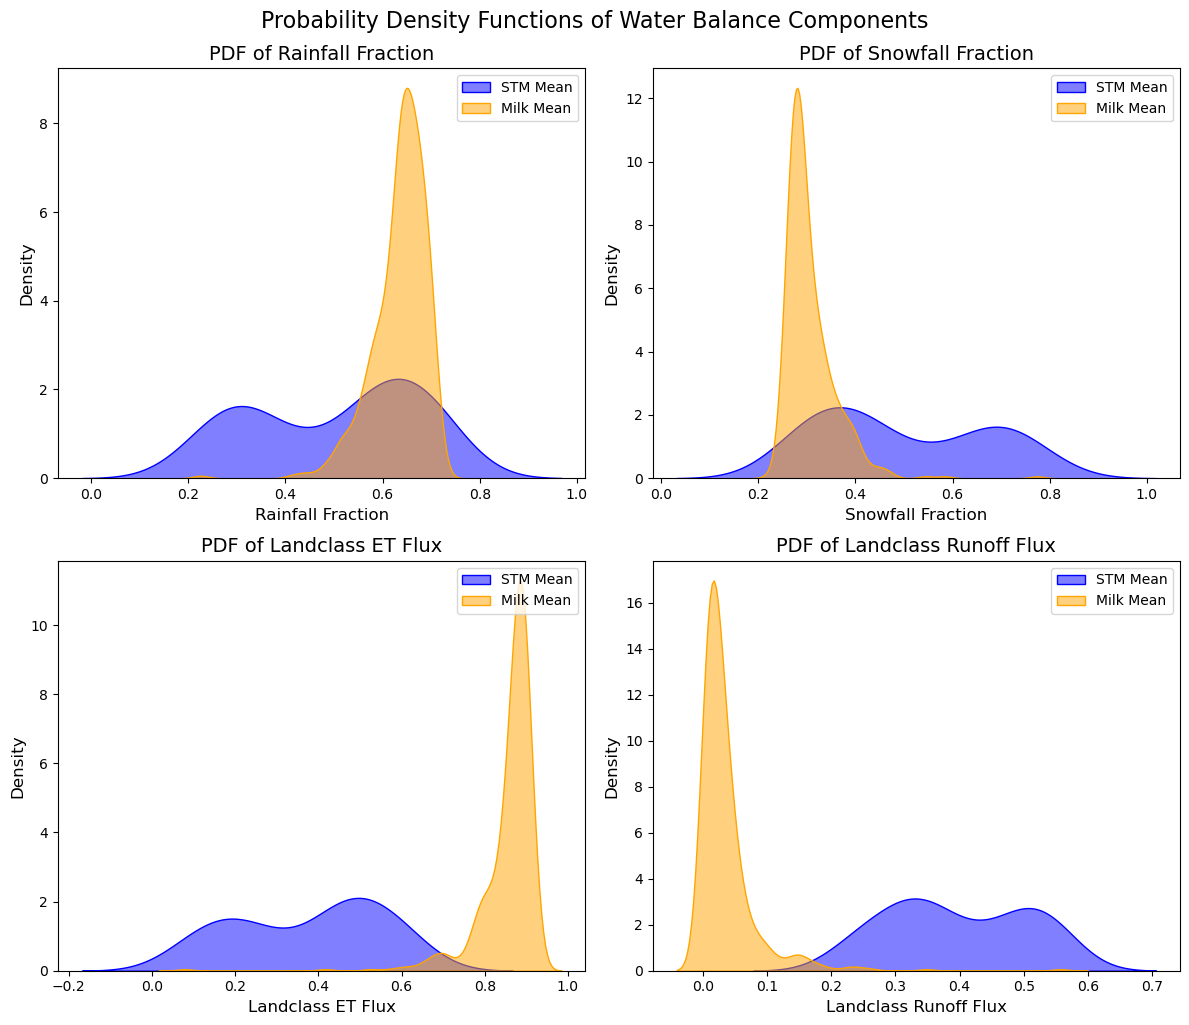

In [37]:
# Calculate the mean for the first range (58183 to 58240)
stm_mean = merged_results.loc[58183:58240, columns_to_plot]

# Calculate the mean for the second range (>58240 to 58675)
milk_mean = merged_results.loc[58241:58675, columns_to_plot]

# Set up the subplots - 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of column names to plot
for i, column in enumerate(columns_to_plot):
    # Plotting the PDF for the 'stm_mean' range
    sns.kdeplot(stm_mean[column], ax=axes[i], color='blue', fill=True, label='STM Mean', alpha=0.5)
    
    # Plotting the PDF for the 'milk_mean' range
    sns.kdeplot(milk_mean[column], ax=axes[i], color='orange', fill=True, label='Milk Mean', alpha=0.5)
    
    # Set title and labels
    axes[i].set_title(f'PDF of {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()
# Add a title for the entire plot
fig.suptitle('Probability Density Functions of Water Balance Components', fontsize=16, y=1.02)

# Show the plot
plt.show()